# Data Set

To train this CNN I have used a database with more than 31,500 images from 45 classes and have variety to weather, location and distance. 
Publication of the database:  G. Cheng, J. Han, X. Lu. Remote Sensing Image Scene Classification: Benchmark and State of the Art. Proceedings of the IEEE.

### CODE

In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [2]:
import os
print(os.getcwd())  # 打印当前工作目录
print(os.listdir())  # 列出当前目录下的文件

D:\jack\cnn
['.idea', '.ipynb_checkpoints', 'Cloud detection -1207_03-restruct-CNN.ipynb', 'Cloud detection -1207_03-restruct-CNN.ipynb~', 'CloudDetectionGUI.py', 'CloudDetectionGUIGrabCam.py', 'ISatelitales']


In [3]:
import tensorflow as tf
print(tf.__file__)  # 打印 TensorFlow 的安装路径

C:\Users\10600\.conda\envs\jack\lib\site-packages\tensorflow\__init__.py


In [4]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import random
import pandas as pd

### 1. Import images



In [5]:
dirname = os.path.join(os.getcwd(), 'ISatelitales')
imgpath = dirname + os.sep # os.sep es = \

image = [] #list with images 
IdCategory = [] #1 is could,0 is no cloud
IdImage = [] #list of img index
indexImage = 0 #img index begin with 0


for ruta, carpetas, filenames in os.walk(imgpath): # path, folder and file names:

    print(ruta, indexImage)
    for filename in filenames: # looking at all files individually
            
        if ruta == imgpath +'cloud':  # if the image is in the cloud folder
            IdImage.append(indexImage) ; indexImage += 1
            IdCategory.append(1) # if the image have clouds IDcat value is 1
            filepath = os.path.join(ruta, filename) #obtain the image direction 
            imagen = plt.imread(filepath) #obtain the image array.
            image.append(imagen) #save the image in images list
        else: 
            IdImage.append(indexImage) ; indexImage += 1
            IdCategory.append(0) # if the image have clouds IDcat value is 0
            filepath = os.path.join(ruta, filename) #obtain the image direction 
            imagen = plt.imread(filepath) #obtain the image array.
            image.append(imagen) #save the image in images list
print('Total images: ', indexImage)
print('Cloud images: ', sum(IdCategory))

D:\jack\cnn\ISatelitales\ 0
D:\jack\cnn\ISatelitales\airplane 0
D:\jack\cnn\ISatelitales\airport 700
D:\jack\cnn\ISatelitales\baseball_diamond 1400
D:\jack\cnn\ISatelitales\basketball_court 2100
D:\jack\cnn\ISatelitales\beach 2800
D:\jack\cnn\ISatelitales\bridge 3500
D:\jack\cnn\ISatelitales\chaparral 4200
D:\jack\cnn\ISatelitales\church 4900
D:\jack\cnn\ISatelitales\circular_farmland 5600
D:\jack\cnn\ISatelitales\cloud 6300
D:\jack\cnn\ISatelitales\commercial_area 7000
D:\jack\cnn\ISatelitales\dense_residential 7700
D:\jack\cnn\ISatelitales\desert 8400
D:\jack\cnn\ISatelitales\forest 9100
D:\jack\cnn\ISatelitales\freeway 9800
D:\jack\cnn\ISatelitales\golf_course 10500
D:\jack\cnn\ISatelitales\ground_track_field 11200
D:\jack\cnn\ISatelitales\harbor 11900
D:\jack\cnn\ISatelitales\industrial_area 12600
D:\jack\cnn\ISatelitales\intersection 13300
D:\jack\cnn\ISatelitales\island 14000
D:\jack\cnn\ISatelitales\lake 14700
D:\jack\cnn\ISatelitales\meadow 15400
D:\jack\cnn\ISatelitales\medium

In [6]:
cat=IdCategory
imageList=image

### 2. Division of the set into subsets training, validation and testing
It is necessary to separate the dataset into 3 groups:
* Train: will be used to train the CNN, it is the largest subset, it is 49% of the total images.
* Test: Used to calculate the error when the CNN is being trained, it is 21% of the total images.
* Validation: Used to validate the test score after training the CNN with a new data set, it is 30% of the total images.

This dataset has 31500 images, but only 700 have clouds, 2.2%. We have an imbalanced dataset, training a CNN with this ratio is a mistake. For this reason it is necessary to modify the ratio in the trining, test and validation dataset. After many tests, the best ratios are:
25% of images with clouds and 75% of images without clouds.

* Train: 30% of images with clouds.
* Test: 50% of images with clouds.
* Validation: 25% of images with clouds.



Cloud-free images filtering function

In [7]:
def filter_proportion(data_set_cat, data_set_im, rat_accept):
    Cat = [] 
    Im = []
    con1= 0 #counter Cloud-free images
    con2= 0 #counter cloud images
    lim = len(data_set_cat)
    for i in range(lim) :
        if data_set_cat[i] == 0:
            R=random.random()
            if R < rat_accept:
                con1 += 1
                Im.append(data_set_im[i])
                Cat.append(data_set_cat[i])

        elif data_set_cat[i] == 1:
            con2 += 1
            Im.append(data_set_im[i])
            Cat.append(data_set_cat[i])


    Cat = np.array(Cat)
    Im = np.array(Im, dtype=np.uint8)
    print ('Ratio cloud images: ',con2/(con1+con2) * 100, '%')
    del data_set_im; del data_set_cat
    
    return Im, Cat
    

Separate the data set into data subsets

In [8]:
#subsets train-test and validation
all_Im, validation_Im_origin, all_Cat, validation_Cat_origin = train_test_split(imageList, cat, test_size=0.1, random_state = 18) 
del imageList; del cat

#subsets train test
train_Im_origin,test_Im_origin,train_Cat_origin,test_Cat_origin = train_test_split(all_Im, all_Cat, test_size=0.15, random_state = 18)
del all_Im; del all_Cat



In [9]:
#import keras
#from keras import optimizers
#from keras.utils import to_categorical

import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(physical_devices[0],'GPU')
from tensorflow import keras
from keras import optimizers
from keras.utils import to_categorical

from keras.models import Sequential,Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
#from keras.layers.normalization import BatchNormalization
#from keras.layers.advanced_activations import LeakyReLU
from keras.layers import LeakyReLU
from keras.models import load_model

In [10]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.src.legacy.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(
    rotation_range=20,  # 随机旋转的角度范围
    width_shift_range=0.2,  # 随机水平移动的范围
    height_shift_range=0.2,  # 随机垂直移动的范围
    shear_range=0.2,  # 剪切强度
    zoom_range=0.2,  # 随机缩放的范围
    horizontal_flip=True,  # 随机水平翻转
    fill_mode='nearest'
)

# 使用.flow_images()方法来增强图像

# Filtering unclouded images from subsets

Ratio cloud images:  30.165289256198346 %
242
2464


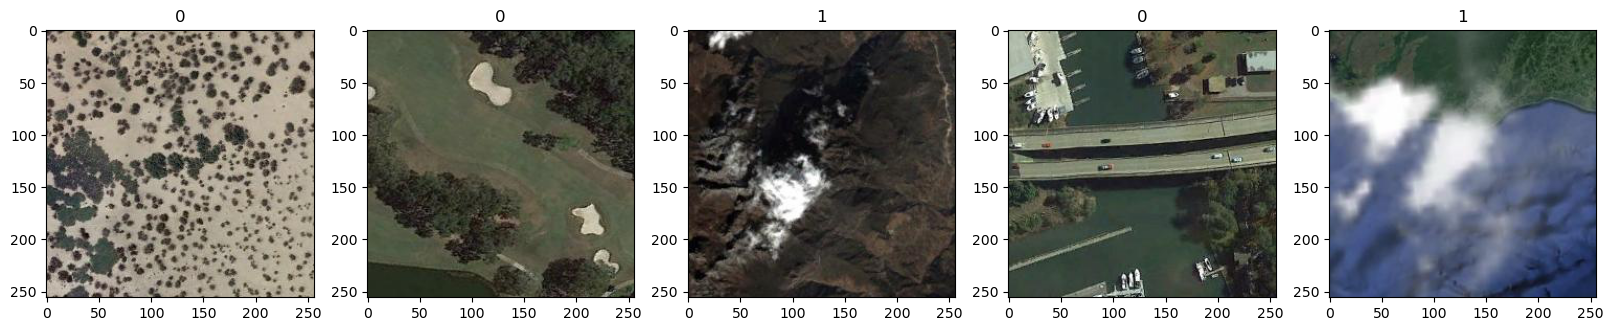

In [11]:
valIm, valCat = filter_proportion(validation_Cat_origin, validation_Im_origin, rat_accept=0.07)

plt.figure(figsize=(20,10))
col = 5
for i in range(col):
    plt.subplot(5//col+1,col,i+1)
    plt.imshow(valIm[i])
    plt.title(valCat[i])

print(len(valIm))
print(len(validation_Im_origin))

Ratio cloud images:  36.394557823129254 %
1470
18846


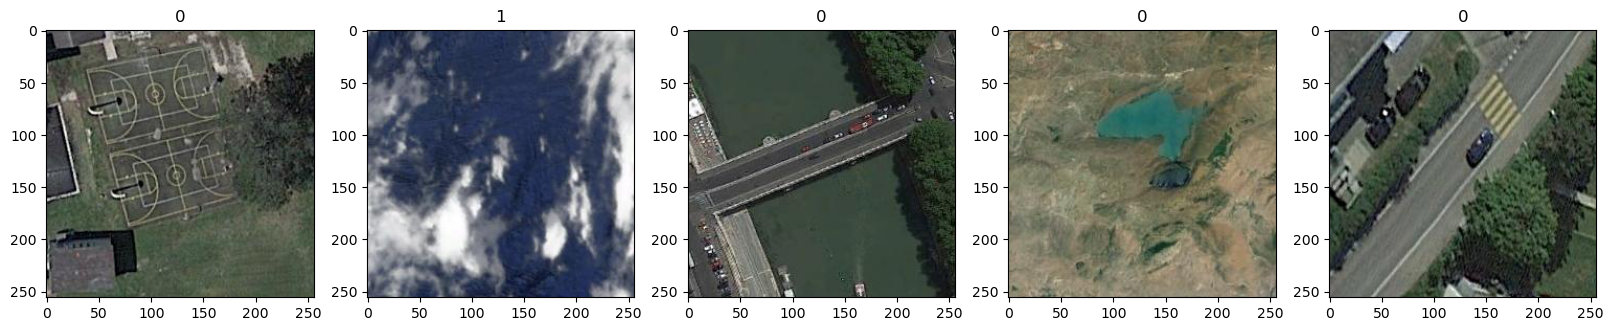

In [12]:
train_Im, train_Cat = filter_proportion(train_Cat_origin, train_Im_origin, rat_accept=0.05)

plt.figure(figsize=(20,10))
col = 5
for i in range(col):
    plt.subplot(5//col+1,col,i+1)
    plt.imshow(train_Im[i])
    plt.title(train_Cat[i])

print(len(train_Im))
print(len(train_Im_origin))

Ratio cloud images:  55.42168674698795 %
166
3326


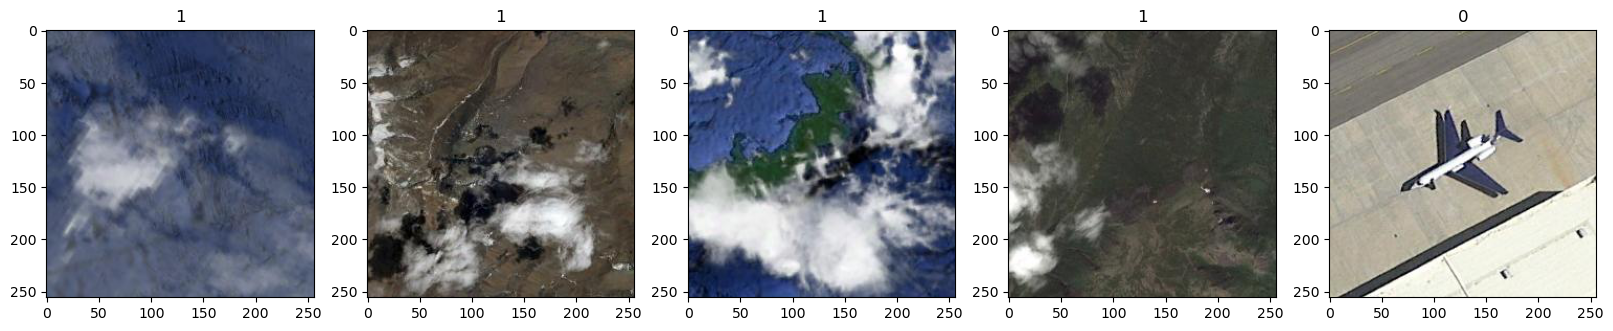

In [13]:
testIm, testCat = filter_proportion(test_Cat_origin, test_Im_origin, rat_accept=0.025)

plt.figure(figsize=(20,10))
col = 5
for i in range(col):
    plt.subplot(5//col+1,col,i+1)
    plt.imshow(testIm[i])
    plt.title(testCat[i])

print(len(testIm))
print(len(test_Im_origin))

### 3. Image processing

All images are the same size, so the only step will be to normalize the pixel value in the arrays. This step is necessary for the best performance of the CNN.

In [14]:
valIm = valIm / 255.
train_Im = train_Im / 255.
testIm = testIm / 255.

### 4. Develop the CNN

In [15]:
from keras.layers import Layer
import keras.backend as K
import tensorflow as tf

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', 
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.tanh(tf.matmul(x, self.W) + self.b)  # Change K.dot to tf.matmul
        a = tf.nn.softmax(e, axis=1)  # Change K.softmax to tf.nn.softmax
        output = x * a
        return output


    def compute_output_shape(self, input_shape):
        return input_shape

# Create the CNN structure

In [16]:
modelCNN = Sequential()
modelCNN.add(Conv2D(60, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
modelCNN.add(MaxPooling2D((4, 4)))

modelCNN.add(Conv2D(120, (3, 3), activation='relu')) #padding default is valid
modelCNN.add(MaxPooling2D((2, 2)))

modelCNN.add(Dropout(0.5))
modelCNN.add(Conv2D(200, (3, 3), activation='relu'))
modelCNN.add(MaxPooling2D((2, 2)))
modelCNN.add(Conv2D(250, (3, 3), activation='relu'))

modelCNN.add(Dropout(0.5))
modelCNN.add(Flatten())
modelCNN.add(Dense(512, activation='relu'))
modelCNN.add(Dense(1, activation='sigmoid'))

In [17]:
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 60)      1680      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 60)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 120)       64920     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 120)      0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 31, 31, 120)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 200)       2

### 5. Training the CNN

In [18]:
import tensorflow as tf
from keras.metrics import Precision, Recall, AUC, PrecisionAtRecall


def precision(y_true, y_pred):
    
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision_value


def recall(y_true, y_pred):
    
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall_value


def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)  # Rename the local variable to avoid conflict
    recall_value = recall(y_true, y_pred)
    return 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))


def specificity(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 0, 1)
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    specificity_value = true_negatives / (possible_negatives + tf.keras.backend.epsilon())
    return specificity_value


In [19]:
train_generator = datagen.flow(train_Im, train_Cat, batch_size=32)

In [20]:
modelCNN.compile(optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['acc', precision, recall, f1_score, specificity])
#modelo2a = modelo2.fit(x=entrIm, y=entrCat, batch_size=32, epochs=30, verbose=1, validation_data=(testIm, testCat), shuffle=True)

In [21]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(physical_devices[0],'GPU')
model_jack1 = modelCNN.fit(
    train_generator,
    steps_per_epoch=int(len(train_Im) / 32),  # Cast the result to an integer
    epochs=30,
    verbose=1,
    validation_data=(testIm, testCat),
    shuffle=True
)

Epoch 1/30
45/45 [==============================] - 22s 300ms/step - loss: 0.6321 - acc: 0.6836 - precision: 0.4197 - recall: 0.3083 - f1_score: 0.2953 - specificity: 0.8982 - val_loss: 0.4755 - val_acc: 0.7771 - val_precision: 0.7140 - val_recall: 1.0000 - val_f1_score: 0.8301 - val_specificity: 0.5221
Epoch 2/30
45/45 [==============================] - 12s 276ms/step - loss: 0.4104 - acc: 0.8060 - precision: 0.7919 - recall: 0.7115 - f1_score: 0.7175 - specificity: 0.8488 - val_loss: 0.3890 - val_acc: 0.8253 - val_precision: 0.9270 - val_recall: 0.7915 - val_f1_score: 0.8506 - val_specificity: 0.9314
Epoch 3/30
45/45 [==============================] - 13s 276ms/step - loss: 0.3706 - acc: 0.8387 - precision: 0.7960 - recall: 0.7689 - f1_score: 0.7603 - specificity: 0.8757 - val_loss: 0.4733 - val_acc: 0.7470 - val_precision: 0.9535 - val_recall: 0.6474 - val_f1_score: 0.7494 - val_specificity: 0.9677
Epoch 4/30
45/45 [==============================] - 13s 279ms/step - loss: 0.3496 - a

# save the model

In [22]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_pred_proba = modelCNN.predict(valIm)
roc_auc = roc_auc_score(valCat, y_pred_proba)
pr_auc = average_precision_score(valCat, y_pred_proba)

8/8 [==============================] - 0s 57ms/step


In [23]:
modelCNN.save("modle-cnn-v1.keras")
modelCNN.save("modle-cnn-v1.h5")

### 6. CNN Evaluation
Test with validation Dataset

In [24]:
test_eval = modelCNN.evaluate(valIm, valCat, verbose=1)
 
print('Validation loss:', test_eval[0])
print('Validation accuracy:', test_eval[1])

8/8 [==============================] - 0s 21ms/step - loss: 0.0594 - acc: 0.9752 - precision: 1.0000 - recall: 0.9089 - f1_score: 0.9468 - specificity: 1.0000
Validation loss: 0.05937054753303528
Validation accuracy: 0.9752066135406494


Represent how the loss value and acc value change with epoch

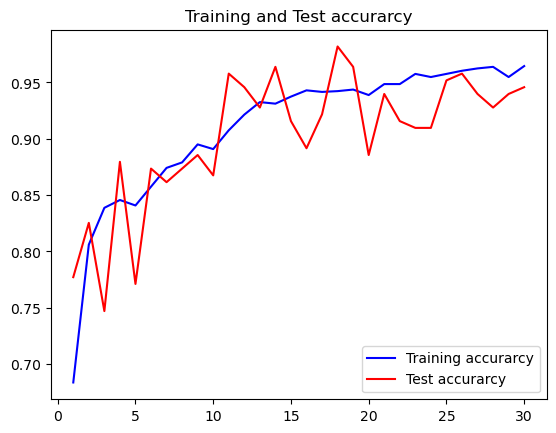

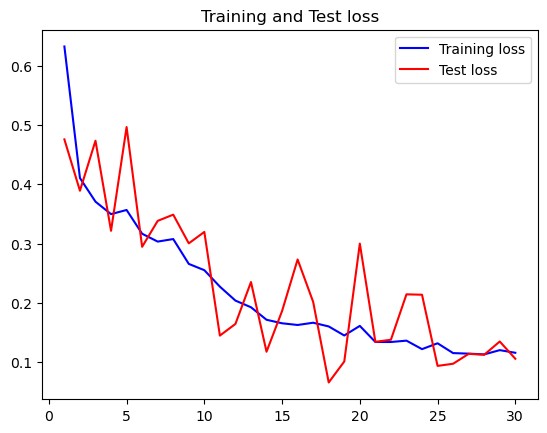

In [25]:
val_loss = model_jack1.history['val_loss'] #loss value
val_acc = model_jack1.history['val_acc'] #acc value
loss = model_jack1.history['loss'] #historical loss array
acc = model_jack1.history['acc'] #historical acc array

X1a1 = range(1, len(acc)+1)
plt.plot(X1a1, acc,'b', label='Training accurarcy')
plt.plot(X1a1, val_acc,'r', label='Test accurarcy')
plt.title('Training and Test accurarcy')
plt.legend()

plt.figure()
plt.plot(X1a1, loss, 'b', label='Training loss')
plt.plot(X1a1, val_loss, 'r',label='Test loss')
plt.title('Training and Test loss')
plt.legend()


plt.show()

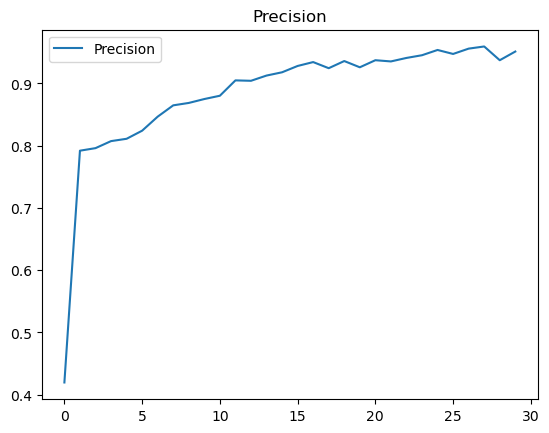

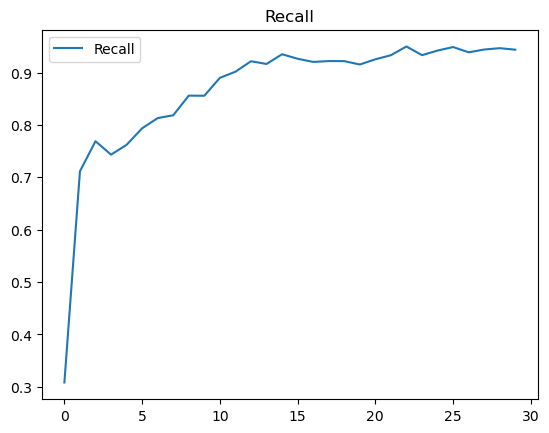

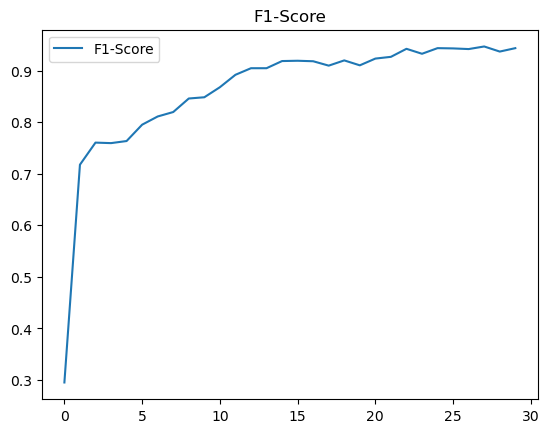

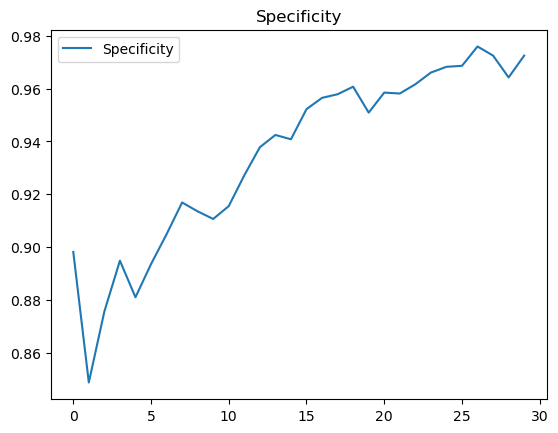

In [26]:
import matplotlib.pyplot as plt
historia = model_jack1
# 绘制精确率和召回率
plt.plot(historia.history['precision'], label='Precision')
plt.title('Precision')
plt.legend()
plt.savefig('precision_a_plot.png', dpi=600)
plt.show()


plt.plot(historia.history['recall'], label='Recall')
plt.title('Recall')
plt.legend()
plt.savefig('recall_a_plot.png', dpi=600)
plt.show()


plt.plot(historia.history['f1_score'], label='F1-Score')
plt.title('F1-Score')
plt.legend()
plt.savefig('F1-Score_a_plot.png', dpi=600)
plt.show()

plt.plot(historia.history['specificity'], label='Specificity')
plt.title('Specificity')
plt.legend()
plt.savefig('specificity_a_plot.png', dpi=600)
plt.show()

#Validation

In [27]:
nub_pred = modelCNN.predict(valIm, batch_size=32, verbose=1) 
nub_predicted = np.argmax(nub_pred, axis=1)  

8/8 [==============================] - 0s 20ms/step


Calculate the ROC curve values

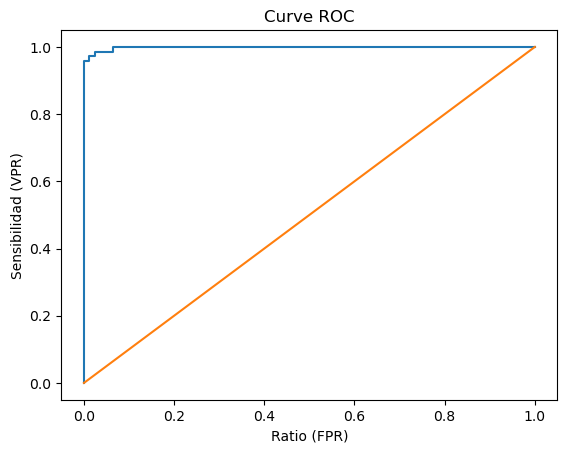

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(valCat , nub_pred)

plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'-')
plt.xlabel('Ratio (FPR)')
plt.ylabel('Sensibilidad (VPR)')
plt.title('Curve ROC')
plt.show()

In [29]:
AUC=roc_auc_score ( valCat ,  nub_pred) #Area curva roc
print("Area of curve ROC=",AUC)

Area of curve ROC= 0.9986220312879954


Other evaluation values for the CNN. In this model the positive case is when it is an image with a cloud and the negative case is when it is an image without a cloud.

In [30]:
dim = valCat.shape[0]
nv = 0; nf = 0; dv= 0; df = 0; na=0
cn = 0; cd= 0
inf=[]; idf=[]
for i in range(dim):
    if nub_pred[i] >= 0.5 and valCat[i] == 1:
        nv +=1
        cn +=1
    elif nub_pred[i] >= 0.5 and valCat[i] == 0:
        nf +=1
        inf.append(valIm[i])
        cd +=1
    elif nub_pred[i] < 0.5 and valCat[i] == 0:
        dv +=1
        cd +=1
    else :
        df +=1
        idf.append(valIm[i])
        cn +=1
    
print('True Positive TF=',nv)
print('False Positive FP=',nf)
print('True Negative TN=',dv)
print('False Negative FN=',df)
print('Sensitivity VPR=',nv/cn)
print('False positive rate FPR=',nf/cd)
print('Accuracy  ACC=',(nv+dv)/(cn+cd))
print('Specificity SPC=',dv/cd)
print('Positive Predictive Value PPV=',nv/(nv+nf))
print('Negative Predictive Value NPV=',dv/(dv+df))
print('Ratio FDR=',nf/(nf+nv))

True Positive TF= 67
False Positive FP= 0
True Negative TN= 169
False Negative FN= 6
Sensitivity VPR= 0.9178082191780822
False positive rate FPR= 0.0
Accuracy  ACC= 0.9752066115702479
Specificity SPC= 1.0
Positive Predictive Value PPV= 1.0
Negative Predictive Value NPV= 0.9657142857142857
Ratio FDR= 0.0


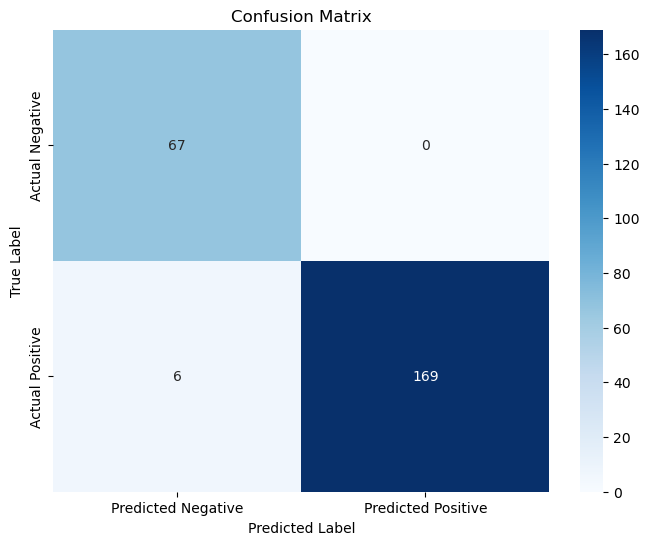

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# nv, nf, dv, df

# 混淆矩阵
conf_matrix = [[nv, nf],  # True Positive, False Positive
               [df, dv]]  # False Negative, True Negative

# 使用seaborn绘制混淆矩阵的热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

# 添加轴标签和标题
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# 显示图形
plt.show()

Some images that were not correctly predicted

In [32]:
plt.figure(figsize=(20, 10))
col = 8
rows = (len(inf) // col) + (1 if len(inf) % col != 0 else 0)  # Calculate rows based on number of images
for i in range(len(inf)):
    plt.subplot(rows, col, i + 1)  # Update subplot grid size
    plt.imshow(inf[i])


<Figure size 2000x1000 with 0 Axes>

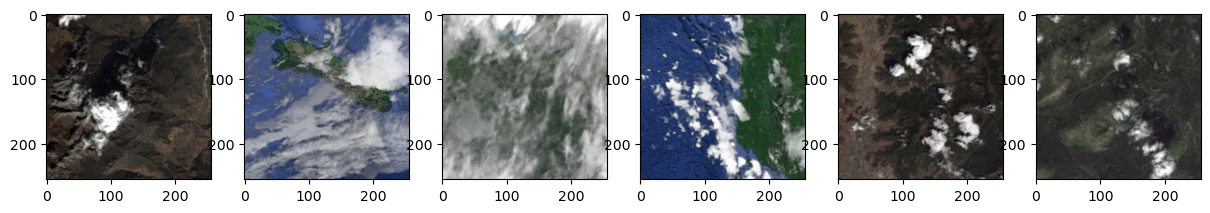

In [33]:
plt.figure(figsize=(20, 10))
col = 8
rows = (len(idf) // col) + (1 if len(idf) % col != 0 else 0)  # Calculate rows based on number of images
for i in range(len(idf)):
    plt.subplot(rows, col, i + 1)  # Update subplot grid size
    plt.imshow(idf[i])

In [ ]:
###ATT-CNN


In [34]:
modelACNN = Sequential()
modelACNN.add(Conv2D(60, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
modelACNN.add(MaxPooling2D((4, 4)))

modelACNN.add(Conv2D(120, (3, 3), activation='relu')) #padding default is valid
modelACNN.add(MaxPooling2D((2, 2)))

modelACNN.add(Dropout(0.5))
modelACNN.add(Conv2D(200, (3, 3), activation='relu'))
modelACNN.add(MaxPooling2D((2, 2)))
modelACNN.add(Conv2D(250, (3, 3), activation='relu'))

modelACNN.add(Dropout(0.5))

modelACNN.add(AttentionLayer())

modelACNN.add(Flatten())
modelACNN.add(Dense(512, activation='relu'))
modelACNN.add(Dense(1, activation='sigmoid'))

In [38]:
modelACNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 60)      1680      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 60)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 120)       64920     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 31, 31, 120)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 31, 31, 120)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 29, 29, 200)      

In [44]:
modelACNN.compile(optimizers.RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['acc', precision, recall, f1_score, specificity])
#modelo2a = modelo2.fit(x=entrIm, y=entrCat, batch_size=32, epochs=30, verbose=1, validation_data=(testIm, testCat), shuffle=True)

In [45]:
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(physical_devices[0],'GPU')
model_jack2 = modelACNN.fit(
    train_generator,
    steps_per_epoch=int(len(train_Im) / 32),  # Cast the result to an integer
    epochs=30,
    verbose=1,
    validation_data=(testIm, testCat),
    shuffle=True
)

Epoch 1/30
45/45 [==============================] - 14s 286ms/step - loss: 0.6207 - acc: 0.6426 - precision: 0.1844 - recall: 0.1434 - f1_score: 0.1338 - specificity: 0.9390 - val_loss: 0.5986 - val_acc: 0.5964 - val_precision: 0.9583 - val_recall: 0.2955 - val_f1_score: 0.4388 - val_specificity: 0.9761
Epoch 2/30
45/45 [==============================] - 12s 276ms/step - loss: 0.4405 - acc: 0.7858 - precision: 0.7933 - recall: 0.6312 - f1_score: 0.6457 - specificity: 0.8714 - val_loss: 0.5148 - val_acc: 0.7169 - val_precision: 0.9238 - val_recall: 0.5508 - val_f1_score: 0.6789 - val_specificity: 0.9594
Epoch 3/30
45/45 [==============================] - 12s 276ms/step - loss: 0.3945 - acc: 0.8234 - precision: 0.7882 - recall: 0.7155 - f1_score: 0.7266 - specificity: 0.8857 - val_loss: 0.4555 - val_acc: 0.7892 - val_precision: 0.9201 - val_recall: 0.7367 - val_f1_score: 0.8121 - val_specificity: 0.9314
Epoch 4/30
45/45 [==============================] - 12s 275ms/step - loss: 0.3755 - a

In [46]:
modelACNN.save("modle-att-cnn-v1.keras")
modelACNN.save("modle-att-cnn-v1.h5")